In [1]:
from astropy.table import Table
import matplotlib.pyplot as plt
import numpy as np
import corner

from corecomposition import build_catalog, measure_radius, build, analyze
import wdphoto
import configparser

G = 6.674e-11
mass_sun = 1.9884e30
radius_sun = 6.957e8
c = 2.99e8

In [2]:
catpath = 'elbadry.csv'
confpath = 'data/gold.ini'
outpath = 'data/test.csv'

basecat = Table.read(catpath)
config = configparser.ConfigParser()
config.read(confpath)

['data/gold.ini']

In [3]:
basecat, targets, engine_keys = build(config, basecat)

Building Catalog


  0%|          | 0/9 [00:00<?, ?it/s]

In [ ]:
bands = config['radius']['pyphot_bands'].split(' ')

co_hrich_model = wdphoto.LaPlataInterpolator(bands, massive_params = ('CO', 'Hrich'))
co_hdef_model = wdphoto.LaPlataInterpolator(bands, massive_params = ('CO', 'Hdef'))

one_hrich_model = wdphoto.LaPlataInterpolator(bands, massive_params = ('ONe', 'Hrich'))
one_hdef_model = wdphoto.LaPlataInterpolator(bands, massive_params = ('ONe', 'Hdef'))

In [ ]:
targets

wd_solution_id,ms_solution_id,wd_source_id,ms_source_id,wd_random_index,ms_random_index,wd_ref_epoch,ms_ref_epoch,wd_ra,ms_ra,wd_ra_error,ms_ra_error,wd_dec,ms_dec,wd_dec_error,ms_dec_error,wd_parallax,ms_parallax,wd_parallax_error,ms_parallax_error,wd_parallax_over_error,ms_parallax_over_error,wd_pm,ms_pm,wd_pmra,ms_pmra,wd_pmra_error,ms_pmra_error,wd_pmdec,ms_pmdec,wd_pmdec_error,ms_pmdec_error,wd_ra_dec_corr,ms_ra_dec_corr,wd_ra_parallax_corr,ms_ra_parallax_corr,wd_ra_pmra_corr,ms_ra_pmra_corr,wd_ra_pmdec_corr,ms_ra_pmdec_corr,wd_dec_parallax_corr,ms_dec_parallax_corr,wd_dec_pmra_corr,ms_dec_pmra_corr,wd_dec_pmdec_corr,ms_dec_pmdec_corr,wd_parallax_pmra_corr,ms_parallax_pmra_corr,wd_parallax_pmdec_corr,ms_parallax_pmdec_corr,wd_pmra_pmdec_corr,ms_pmra_pmdec_corr,wd_astrometric_n_obs_al,ms_astrometric_n_obs_al,wd_astrometric_n_obs_ac,ms_astrometric_n_obs_ac,wd_astrometric_n_good_obs_al,ms_astrometric_n_good_obs_al,wd_astrometric_n_bad_obs_al,ms_astrometric_n_bad_obs_al,wd_astrometric_gof_al,ms_astrometric_gof_al,wd_astrometric_chi2_al,ms_astrometric_chi2_al,wd_astrometric_excess_noise,ms_astrometric_excess_noise,wd_astrometric_excess_noise_sig,ms_astrometric_excess_noise_sig,wd_astrometric_params_solved,ms_astrometric_params_solved,wd_astrometric_primary_flag,ms_astrometric_primary_flag,wd_nu_eff_used_in_astrometry,ms_nu_eff_used_in_astrometry,wd_pseudocolour,ms_pseudocolour,wd_pseudocolour_error,ms_pseudocolour_error,wd_ra_pseudocolour_corr,ms_ra_pseudocolour_corr,wd_dec_pseudocolour_corr,ms_dec_pseudocolour_corr,wd_parallax_pseudocolour_corr,ms_parallax_pseudocolour_corr,wd_pmra_pseudocolour_corr,ms_pmra_pseudocolour_corr,wd_pmdec_pseudocolour_corr,ms_pmdec_pseudocolour_corr,wd_astrometric_matched_transits,ms_astrometric_matched_transits,wd_visibility_periods_used,ms_visibility_periods_used,wd_astrometric_sigma5d_max,ms_astrometric_sigma5d_max,wd_matched_transits,ms_matched_transits,wd_new_matched_transits,ms_new_matched_transits,wd_matched_transits_removed,ms_matched_transits_removed,wd_ipd_gof_harmonic_amplitude,ms_ipd_gof_harmonic_amplitude,wd_ipd_gof_harmonic_phase,ms_ipd_gof_harmonic_phase,wd_ipd_frac_multi_peak,ms_ipd_frac_multi_peak,wd_ipd_frac_odd_win,ms_ipd_frac_odd_win,wd_ruwe,ms_ruwe,wd_scan_direction_strength_k1,ms_scan_direction_strength_k1,wd_scan_direction_strength_k2,ms_scan_direction_strength_k2,wd_scan_direction_strength_k3,ms_scan_direction_strength_k3,wd_scan_direction_strength_k4,ms_scan_direction_strength_k4,wd_scan_direction_mean_k1,ms_scan_direction_mean_k1,wd_scan_direction_mean_k2,ms_scan_direction_mean_k2,wd_scan_direction_mean_k3,ms_scan_direction_mean_k3,wd_scan_direction_mean_k4,ms_scan_direction_mean_k4,wd_duplicated_source,ms_duplicated_source,wd_phot_g_n_obs,ms_phot_g_n_obs,wd_phot_g_mean_flux,ms_phot_g_mean_flux,wd_phot_g_mean_flux_error,ms_phot_g_mean_flux_error,wd_phot_g_mean_flux_over_error,ms_phot_g_mean_flux_over_error,wd_phot_g_mean_mag,ms_phot_g_mean_mag,wd_phot_bp_n_obs,ms_phot_bp_n_obs,wd_phot_bp_mean_flux,ms_phot_bp_mean_flux,wd_phot_bp_mean_flux_error,ms_phot_bp_mean_flux_error,wd_phot_bp_mean_flux_over_error,ms_phot_bp_mean_flux_over_error,wd_phot_bp_mean_mag,ms_phot_bp_mean_mag,wd_phot_rp_n_obs,ms_phot_rp_n_obs,wd_phot_rp_mean_flux,ms_phot_rp_mean_flux,wd_phot_rp_mean_flux_error,ms_phot_rp_mean_flux_error,wd_phot_rp_mean_flux_over_error,ms_phot_rp_mean_flux_over_error,wd_phot_rp_mean_mag,ms_phot_rp_mean_mag,wd_phot_bp_n_contaminated_transits,ms_phot_bp_n_contaminated_transits,wd_phot_bp_n_blended_transits,ms_phot_bp_n_blended_transits,wd_phot_rp_n_contaminated_transits,ms_phot_rp_n_contaminated_transits,wd_phot_rp_n_blended_transits,ms_phot_rp_n_blended_transits,wd_phot_proc_mode,ms_phot_proc_mode,wd_phot_bp_rp_excess_factor,ms_phot_bp_rp_excess_factor,wd_bp_rp,ms_bp_rp,wd_bp_g,ms_bp_g,wd_g_rp,ms_g_rp,wd_dr2_radial_velocity,ms_dr2_radial_velocity,wd_dr2_radial_velocity_error,ms_dr2_radial_velocity_error,wd_dr2_rv_nb_transits,ms_dr2_rv_nb_transits,wd_dr2_rv_template_teff,ms_dr2

In [ ]:
i = 0
obs_mag = np.array([targets[i]['wd_phot_bp_mean_mag'], targets[i]['wd_phot_rp_mean_mag']])
e_obs_mag = np.array([targets[i]['wd_e_bpmag'], targets[i]['wd_e_rpmag']])
distance = targets['r_med_geo'][i]

In [ ]:
engine = wdphoto.PhotometryEngine(co_hrich_model)
radius, e_radius, teff, e_teff, logg, e_logg, result = engine(obs_mag, e_obs_mag, distance, method='emcee')

100%|██████████| 1000/1000 [00:19<00:00, 51.65it/s]


The chain is shorter than 50 times the integrated autocorrelation time for 2 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 20;
tau: [114.78987039 122.31971292]


AttributeError: 'tuple' object has no attribute 'redchi'

In [ ]:

emcee_plot = corner.corner(result.flatchain, labels=result.var_names,
                           truths=list(result.params.valuesdict().values()))

AttributeError: 'tuple' object has no attribute 'flatchain'

In [ ]:
teff = np.linspace(5000, 75000, 5)
logg = np.linspace(8.5, 9.3, 100)

co_hrich_radius = []
co_hrich_mass = []
co_hrich_vg = []
co_hdef_radius = []
co_hdef_mass = []
co_hdef_vg = []

one_hrich_radius = []
one_hrich_mass = []
one_hrich_vg = []
one_hdef_radius = []
one_hdef_mass = []
one_hdef_vg = []

for j in range(len(teff)):
    radii = [co_hrich_model.radius_interp(teff[j], logg[i]) for i in range(len(logg))]
    masses = [(10**(logg[i] - 2) * (radius_sun * radii[i])**2) / (G * mass_sun) for i in range(len(logg))]    
    co_hrich_vg.append([1e-3 * (G * mass_sun * masses[i]) / (c * radius_sun * radii[i]) for i in range(len(radii))])
    co_hrich_mass.append(masses)
    co_hrich_radius.append(radii)

    radii = [co_hdef_model.radius_interp(teff[j], logg[i]) for i in range(len(logg))]
    masses = [(10**(logg[i] - 2) * (radius_sun * radii[i])**2) / (G * mass_sun) for i in range(len(logg))]
    co_hdef_vg.append([1e-3 * (G * mass_sun * masses[i]) / (c * radius_sun * radii[i]) for i in range(len(radii))])
    co_hdef_mass.append(masses)
    co_hdef_radius.append(radii)

    radii = [one_hrich_model.radius_interp(teff[j], logg[i]) for i in range(len(logg))]
    masses = [(10**(logg[i] - 2) * (radius_sun * radii[i])**2) / (G * mass_sun) for i in range(len(logg))]    
    one_hrich_vg.append([1e-3 * (G * mass_sun * masses[i]) / (c * radius_sun * radii[i]) for i in range(len(radii))])
    one_hrich_mass.append(masses)
    one_hrich_radius.append(radii)

    radii = [one_hdef_model.radius_interp(teff[j], logg[i]) for i in range(len(logg))]
    masses = [(10**(logg[i] - 2) * (radius_sun * radii[i])**2) / (G * mass_sun) for i in range(len(logg))]
    one_hdef_vg.append([1e-3 * (G * mass_sun * masses[i]) / (c * radius_sun * radii[i]) for i in range(len(radii))])
    one_hdef_mass.append(masses)
    one_hdef_radius.append(radii)

co_hrich_radius = np.array(co_hrich_radius)
co_hrich_mass = np.array(co_hrich_mass)
co_hrich_vg = np.array(co_hrich_vg)
co_hdef_radius = np.array(co_hdef_radius)
co_hdef_mass = np.array(co_hdef_mass)
co_hdef_vg = np.array(co_hdef_vg)

one_hrich_radius = np.array(one_hrich_radius)
one_hrich_mass = np.array(one_hrich_mass)
one_hrich_vg = np.array(one_hrich_vg)
one_hdef_radius = np.array(one_hdef_radius)
one_hdef_mass = np.array(one_hdef_mass)
one_hdef_vg = np.array(one_hdef_vg)


Text(0.5, 0, 'Mass $[M_\\odot]$')

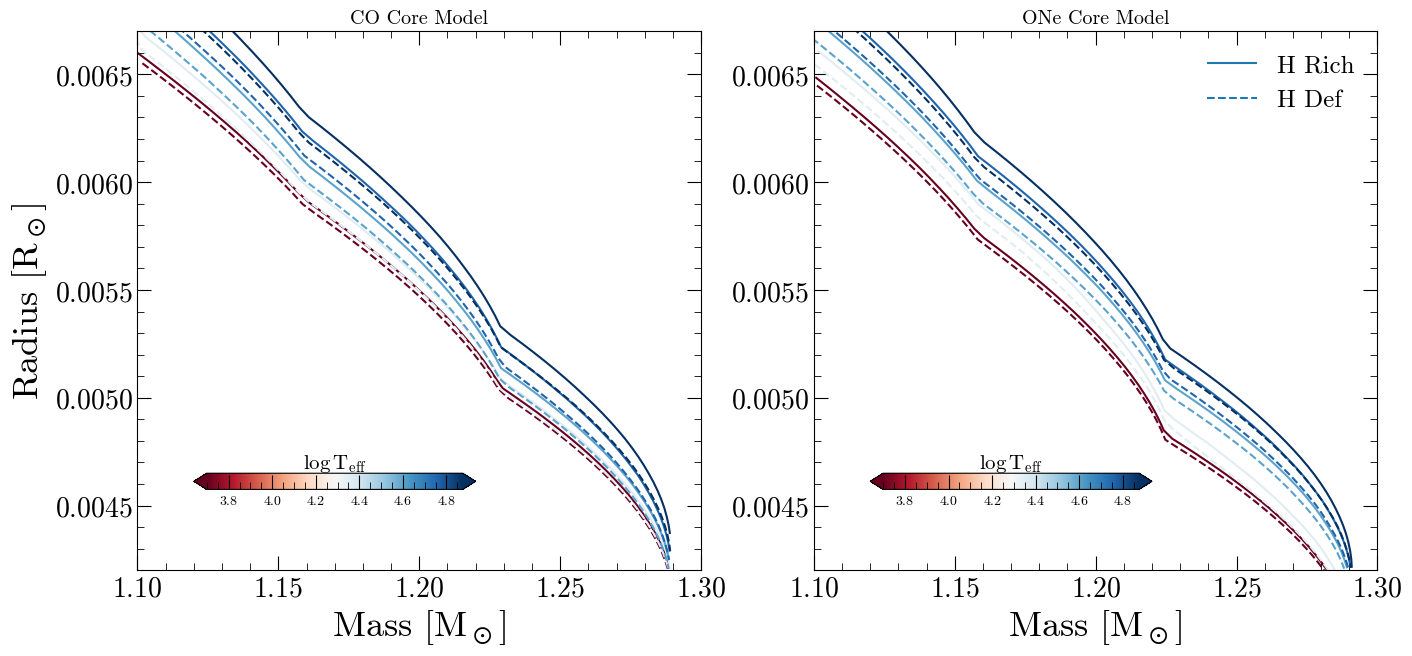

In [ ]:
from matplotlib.collections import LineCollection
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(16, 7))

co_hrich_stack = [np.column_stack([x,y]) for x, y in zip(co_hrich_mass, co_hrich_radius)]
co_hdef_stack = [np.column_stack([x,y]) for x, y in zip(co_hdef_mass, co_hdef_radius)]

one_hrich_stack = [np.column_stack([x,y]) for x, y in zip(one_hrich_mass, one_hrich_radius)]
one_hdef_stack = [np.column_stack([x,y]) for x, y in zip(one_hdef_mass, one_hdef_radius)]


ax1.set_xlim(1.1, 1.3)
ax1.set_ylim(0.0042, 0.0067)
ax1.set_title('CO Core Model')

line_collection = LineCollection(co_hrich_stack, array=np.log10(teff), cmap='RdBu', ls = '-', label='CO H Rich')
ax1.add_collection(line_collection)
line_collection = LineCollection(co_hdef_stack, array=np.log10(teff), cmap='RdBu', ls = '--', label='CO H Def')
ax1.add_collection(line_collection)

cbaxes = ax1.inset_axes([.1, .15, .5, .03]) 
cb = fig.colorbar(line_collection, cax=cbaxes, orientation='horizontal', extend="both")
cb.set_label(label=r"$\log T_{eff}$",size=15,weight='bold')
cb.ax.tick_params(labelsize=10)
cbaxes.xaxis.set_label_position('top')

ax1.set_xlabel(r'Mass $[M_\odot]$')
ax1.set_ylabel(r'Radius $[R_\odot]$')


ax2.set_xlim(1.1, 1.3)
ax2.set_ylim(0.0042, 0.0067)
ax2.set_title('ONe Core Model')

line_collection = LineCollection(one_hrich_stack, array=np.log10(teff), cmap='RdBu', ls = '-', label='H Rich')
ax2.add_collection(line_collection)
line_collection = LineCollection(one_hdef_stack, array=np.log10(teff), cmap='RdBu', ls = '--', label='H Def')
ax2.add_collection(line_collection)

cbaxes = ax2.inset_axes([.1, .15, .5, .03]) 
cb = fig.colorbar(line_collection, cax=cbaxes, orientation='horizontal', extend="both")
cb.set_label(label=r"$\log T_{eff}$",size=15,weight='bold')
cb.ax.tick_params(labelsize=10)
cbaxes.xaxis.set_label_position('top')

ax2.legend(framealpha=0)
ax2.set_xlabel(r'Mass $[M_\odot]$')


Text(0.5, 0, 'Radius $[R_\\odot]$')

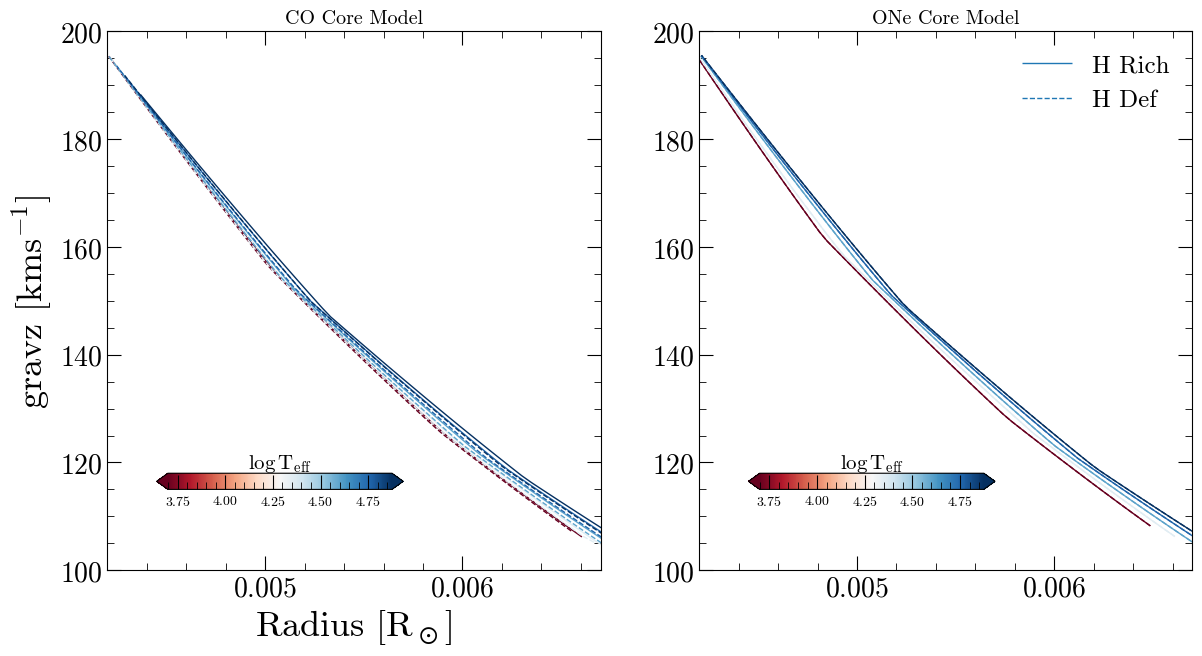

In [ ]:
from matplotlib.collections import LineCollection
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(14, 7))

co_hrich_stack = [np.column_stack([x,y]) for x, y in zip(co_hrich_radius, co_hrich_vg)]
co_hdef_stack = [np.column_stack([x,y]) for x, y in zip(co_hdef_radius, co_hdef_vg)]

one_hrich_stack = [np.column_stack([x,y]) for x, y in zip(one_hrich_radius, one_hrich_vg)]
one_hdef_stack = [np.column_stack([x,y]) for x, y in zip(one_hrich_radius, one_hrich_vg)]


ax1.set_xlim(0.0042, 0.0067)
ax1.set_ylim(100, 200)
ax1.set_title('CO Core Model')

line_collection = LineCollection(co_hrich_stack, array=np.log10(teff), cmap='RdBu', ls = '-', label='CO H Rich', lw=1)
ax1.add_collection(line_collection)
line_collection = LineCollection(co_hdef_stack, array=np.log10(teff), cmap='RdBu', ls = '--', label='CO H Def', lw=1)
ax1.add_collection(line_collection)

cbaxes = ax1.inset_axes([.1, .15, .5, .03]) 
cb = fig.colorbar(line_collection, cax=cbaxes, orientation='horizontal', extend="both")
cb.set_label(label=r"$\log T_{eff}$",size=15,weight='bold')
cb.ax.tick_params(labelsize=10)
cbaxes.xaxis.set_label_position('top')

ax1.set_ylabel(r'gravz $[km s^{-1}]$')
ax1.set_xlabel(r'Radius $[R_\odot]$')


ax2.set_xlim(0.0042, 0.0067)
ax2.set_ylim(100, 200)
ax2.set_title('ONe Core Model')

line_collection = LineCollection(one_hrich_stack, array=np.log10(teff), cmap='RdBu', ls = '-', label='H Rich', lw=1)
ax2.add_collection(line_collection)
line_collection = LineCollection(one_hdef_stack, array=np.log10(teff), cmap='RdBu', ls = '--', label='H Def', lw=1)
ax2.add_collection(line_collection)

cbaxes = ax2.inset_axes([.1, .15, .5, .03]) 
cb = fig.colorbar(line_collection, cax=cbaxes, orientation='horizontal', extend="both")
cb.set_label(label=r"$\log T_{eff}$",size=15,weight='bold')
cb.ax.tick_params(labelsize=10)
cbaxes.xaxis.set_label_position('top')

ax2.legend(framealpha=0)
ax1.set_xlabel(r'Radius $[R_\odot]$')